#                                                Rédolutuion de l'équation de Laplace

### Solution exacte

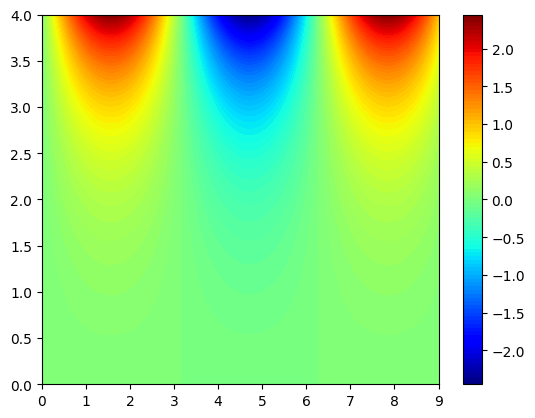

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def u_exact(x , y):
    return (np.sin(x)*np.sinh(y) )/ (np.sin(9)*np.sinh(4))

x = np.linspace(0, 9, 100)
y = np.linspace(0, 4, 100)
x, y = np.meshgrid(x, y)
u_ex = u_exact(x,y)

plt.contourf(x, y, u_ex,levels=100, cmap='jet')
plt.colorbar()
plt.show()


## Résolution avec différence finie

Converged in 2999 iterations


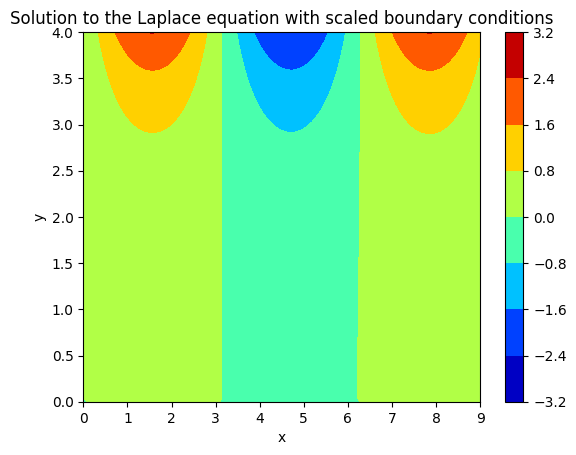

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain and grid spacing
Lx = 9
Ly = 4
Nx = 100
Ny = 100
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Initialize the solution array and set boundary conditions
u = np.zeros((Nx, Ny))
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
u[:, 0] = 0
u[0, :] = 0

# Boundary conditions
u_boundary1 = np.sin(x) / np.sin(9)
u_boundary2 = np.sinh(y) / np.sinh(4)

# Normalize the boundary conditions


# Apply normalized boundary conditions to the solution array
u[:, -1] = u_boundary1
u[-1, :] = u_boundary2

# Solve the Laplace equation
max_iter = 3000
tol = 1e-5  # Tolerance for convergence
for h in range(max_iter):
    u_new = u.copy()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            u_new[i, j] = ((u[i+1, j] + u[i-1, j]) * dy**2 +
                           (u[i, j+1] + u[i, j-1]) * dx**2) / (2 * (dx**2 + dy**2))
    # Check for convergence
    if np.linalg.norm(u - u_new, ord=np.inf) < tol:
        break
    u = u_new

# Denormalize the solution at the boundaries


#u = u * (np.max(u_boundary1) - np.min(u_boundary1)) + np.min(u_boundary1)

# Plot the solution
X, Y = np.meshgrid(x, y)
print(f'Converged in {h} iterations')
plt.contourf(X, Y, u.T, cmap='jet')
plt.colorbar()
plt.title("Solution to the Laplace equation with scaled boundary conditions")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


### creating a fully connected network


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

### Definig The Losses

In [4]:
import torch as tf
import numpy as np
import time





def ui(x, y , pinn):
    return pinn(tf.concat((x, y), dim=1))

# defining the pde (Laplace)
def f(x, y ,pinn):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,pinn)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]
    return u_xx + u_yy 

def f2(x, y ,pinn):
    
    f_pred = f(x, y ,pinn)
    r = (f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )
    return torch.abs(r)
def adaptive_collocation_points(x, y, model, k=1.0):
   
    residuals = f2(x, y, model)
    
    p = residuals**k / torch.sum(residuals**k)
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

    #x_new += (torch.rand_like(x_new) - 0.5) * 0.05
    #y_new += (torch.rand_like(y_new) - 0.5) * 0.05
    return x_new, y_new
#initial and boundary conditions losses
def loss_boundary_1(x , pinn):
    u_boundary =  np.exp(-10*(x**2+1))

    return tf.mean((ui(x , -torch.ones_like(x),pinn) - u_boundary)**2)
def loss_boundary_2(x,pinn):
    u_boundary =  np.exp(-10*(x**2+1))

    return tf.mean((ui(x , torch.ones_like(x),pinn) - u_boundary)**2)

def loss_boundary_3(y,pinn):
    u_boundary =  np.exp(-10*(y**2+1))
  
    return tf.mean((ui( torch.ones_like(y),y,pinn) - u_boundary)**2)

def loss_boundary_4(y ,pinn):
    u_boundary = np.exp(-10*(y**2+1))
  
    return tf.mean((ui( -torch.ones_like(y),y,pinn) - u_boundary)**2)
def check_for_interrupt():
    try:
        time.sleep(0)
    except KeyboardInterrupt:
        print("Interrupted!")
        raise KeyboardInterrupt

# pde loss
def loss_fn(x, y ,pinn):
    

    
    f_pred = f(x, y ,pinn)
    return torch.mean((f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )**2) 


def loss_fn2(x, y ,pinn):

    
    f_pred = f(x, y ,pinn) 
    return torch.mean((f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )**2)

def create_grid(num_points):
    x = np.linspace(-1, 1, num_points)
    y = np.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y






## Normal approach 

Epoch 0, Loss 30.792896270751953, mse : 1218.2452392578125,l2_error: 0.9828595519065857
loss_f: 30.788150787353516 , loss_ic: 0.0017387711559422314 , loss_bc: 0.002013069635722786
Epoch 100, Loss 0.1821601539850235, mse : 2.2755987644195557,l2_error: 0.0028340048156678677
loss_f: 0.18124036490917206 , loss_ic: 0.00024833849602146074 , loss_bc: 0.0005343435768736526
Epoch 200, Loss 0.016140487045049667, mse : 4.385254383087158,l2_error: 0.005615391302853823
loss_f: 0.015952054411172867 , loss_ic: 9.602869613445364e-05 , loss_bc: 0.00012096585851395503
Epoch 300, Loss 0.005540515761822462, mse : 0.43847665190696716,l2_error: 0.00039743591332808137
loss_f: 0.005445810500532389 , loss_ic: 4.803711817658041e-05 , loss_bc: 6.576438499905635e-05
Epoch 400, Loss 0.003399726003408432, mse : 0.23799656331539154,l2_error: 0.00023527471057604998
loss_f: 0.0033264998346567154 , loss_ic: 2.8208361072756816e-05 , loss_bc: 5.445406259241281e-05
Epoch 500, Loss 0.0022013275884091854, mse : 0.1231329962

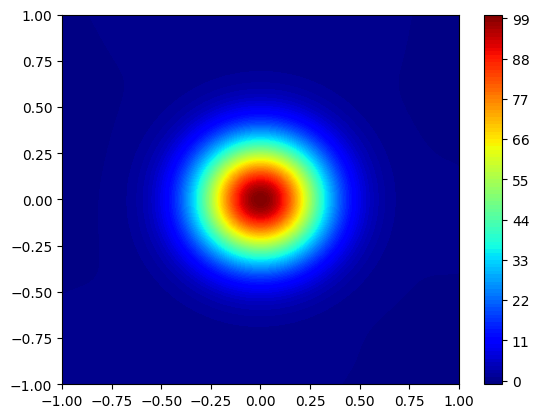

In [10]:
import matplotlib.pyplot as plt

pinn0 = Net(2, 1, 50, 4)
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)

x, y = torch.meshgrid(x, y)

MSE_0 = []
L2_ERROR_0 = []
LOSS_0 = []

optimizer = torch.optim.Adam(pinn0.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
for epoch in range(701):
  


    optimizer.zero_grad()

    loss2 = loss_boundary_1(x.flatten().unsqueeze(1), pinn0)
    loss3 = loss_boundary_2(x.flatten().unsqueeze(1), pinn0)
    loss4 = loss_boundary_3(y.flatten().unsqueeze(1), pinn0)
    
    loss5 = loss_boundary_4(y.flatten().unsqueeze(1), pinn0)
    loss_f = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn0)

    loss = loss_f + loss2 + loss3 + loss4 + loss5
    loss.backward(retain_graph=True)
   
    optimizer.step()
    scheduler.step()



    





    
    if epoch % 100 == 0:
        u_pred_2 = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn0)
        u_pred_2 = u_pred_2.reshape(100, 100)
        u_pred_2 = u_pred_2.detach().numpy()

        u_ex = u_exact(x,y)
        
        MSE_0.append(torch.mean((u_ex - 100*u_pred_2) ** 2))
        LOSS_0.append(loss.item())
        L2_ERROR_0.append(torch.linalg.norm((u_ex - 100*u_pred_2) ** 2)/torch.linalg.norm((u_ex ) ** 2))
        
        print(f'Epoch {epoch}, Loss {loss.item()}, mse : {MSE_0[-1]},l2_error: {L2_ERROR_0[-1]}')
        print(f'loss_f: {loss_f.item()} , loss_ic: {loss3.item() + loss4.item()} , loss_bc: {loss4.item()+loss5.item()}')


u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn0)
#inverse scaling on the boundarys
u_pred = u_pred.reshape(100, 100)
u_pred = u_pred.detach().numpy()


plt.contourf(x.detach().numpy(), y.detach().numpy(), 100*u_pred,levels = 100 , cmap='jet')
plt.colorbar()
plt.show()      



## Adaptative weights

Epoch 0, Loss 7.185733318328857, mse : 1320.850341796875,l2_error: 1.8487532138824463
loss_f: 30.795068740844727 , loss_ic: 0.04717559181153774 , loss_bc: 0.05732806399464607
Epoch 100, Loss 0.48112526535987854, mse : 1.1932867765426636,l2_error: 0.001083673327229917
loss_f: 0.14883293211460114 , loss_ic: 0.0008804503304418176 , loss_bc: 0.000672478970955126
Epoch 200, Loss 0.12344760447740555, mse : 0.5956024527549744,l2_error: 0.0006493186228908598
loss_f: 0.04265914484858513 , loss_ic: 0.00015760844689793885 , loss_bc: 0.00014867928257444873
Epoch 300, Loss 0.02966715767979622, mse : 0.33970877528190613,l2_error: 0.0002895906800404191
loss_f: 0.008469956927001476 , loss_ic: 0.00017738841415848583 , loss_bc: 0.00014878249203320593
Epoch 400, Loss 0.005904692690819502, mse : 0.1181916743516922,l2_error: 0.00011068713502027094
loss_f: 0.0024740893859416246 , loss_ic: 4.758495924761519e-05 , loss_bc: 3.06111469399184e-05
Epoch 500, Loss 0.004360947757959366, mse : 0.0972738265991211,l2_

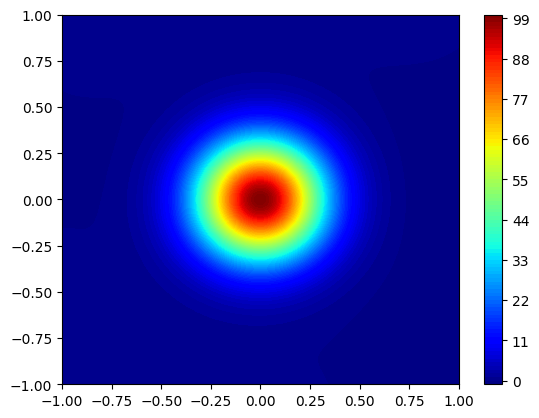

In [8]:
import matplotlib.pyplot as plt


pinn1 = Net(2, 1, 50, 4)
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)

x, y = torch.meshgrid(x, y)





indices = torch.randint(0, 100, (2500, 2))

MSE_1 = []
L2_ERROR_1 = []
LOSS_1 = []
W_i =[]
W_bc = []
W_f = []

    


weight_bc = torch.tensor(1.0, requires_grad=True)
weight_i = torch.tensor(1.0, requires_grad=True)
weight_f = torch.tensor(1.0, requires_grad=True)
optimizer = torch.optim.Adam([{'params':pinn1.parameters()} ,{'params':[weight_bc, weight_i, weight_f]} ], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
for epoch in range(2001):
    check_for_interrupt()


    optimizer.zero_grad()
    loss2 = loss_boundary_1(x.flatten().unsqueeze(1), pinn1)
    loss3 = loss_boundary_2(x.flatten().unsqueeze(1), pinn1)
    loss4 = loss_boundary_3(y.flatten().unsqueeze(1), pinn1)
    
    loss5 = loss_boundary_4(y.flatten().unsqueeze(1), pinn1)
    loss_f = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn1)

    loss = ((loss_f )*tf.exp(-weight_f) +  (loss3 + loss4)*tf.exp(-weight_bc) + (loss2 + loss5)*tf.exp(-weight_i) + torch.abs(weight_bc)**2 + torch.abs(weight_i)**2 + torch.abs(weight_f)**2)*0.5
    loss.backward(retain_graph=True)
   
    optimizer.step()
    scheduler.step()

    #weight_bc = np.exp(-(loss3 + loss4).detach().numpy())
    #weight_i = np.exp(-(loss2 + loss5).detach().numpy())
    #weight_f = np.exp(-(loss_f + loss_for_adaptive_points).detach().numpy())




        
    W_i.append(tf.exp(-weight_i).detach().numpy())
    W_bc.append(tf.exp(-weight_bc).detach().numpy())
    W_f.append(tf.exp(-weight_f).detach().numpy())



    






    if epoch % 100 == 0:
        u_pred_2 = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn1)
        u_pred_2 = u_pred_2.reshape(100, 100)
        u_pred_2 = u_pred_2.detach().numpy()

        u_ex = u_exact(x,y)
        
        MSE_1.append(torch.mean((u_ex - 100*u_pred_2) ** 2))
        LOSS_1.append(loss.item())
        L2_ERROR_1.append(torch.linalg.norm((u_ex - 100*u_pred_2) ** 2)/torch.linalg.norm((u_ex ) ** 2))
        
        print(f'Epoch {epoch}, Loss {loss.item()}, mse : {MSE_1[-1]},l2_error: {L2_ERROR_1[-1]}')
        print(f'loss_f: {loss_f.item()} , loss_ic: {loss3.item() + loss4.item()} , loss_bc: {loss4.item()+loss5.item()}')

u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn1)
#inverse scaling on the boundarys
u_pred = u_pred.reshape(100, 100)
u_pred = u_pred.detach().numpy()


plt.contourf(x.detach().numpy(), y.detach().numpy(), 100*u_pred,levels = 100 , cmap='jet')
plt.colorbar()
plt.show()      


## Adaptive Loss and weights

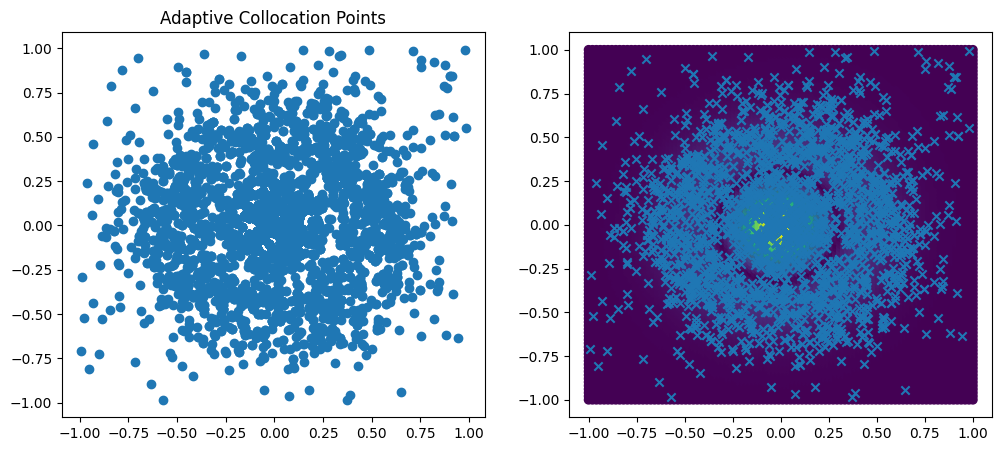

Epoch 0, Loss 13.339717864990234, mse : 737.0914032311272,l2_error: 0.6632062429865679


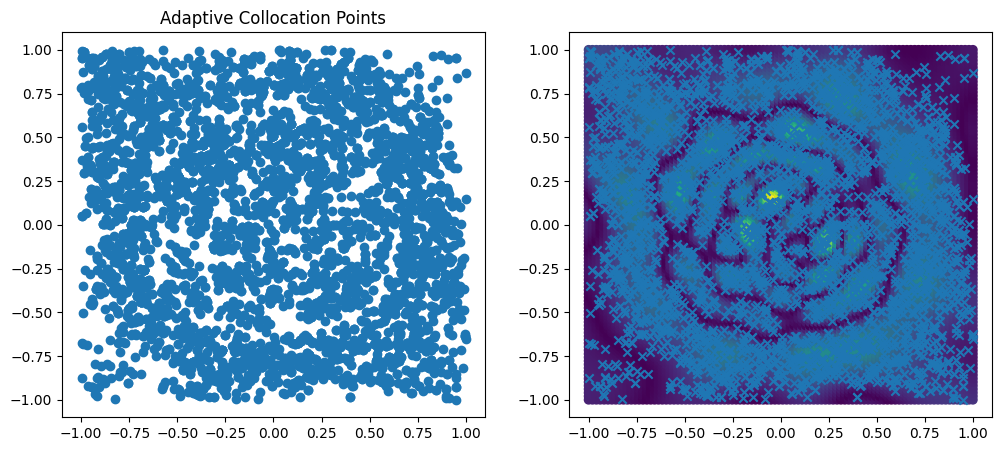

Epoch 100, Loss 0.617718517780304, mse : 1.615528226225546,l2_error: 0.0017430372112461387


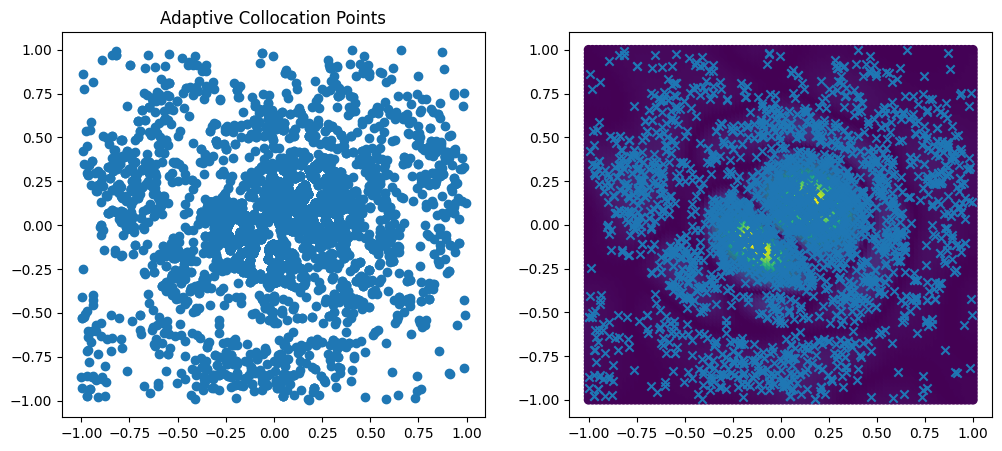

Epoch 200, Loss 0.32894065976142883, mse : 7.144782385317302,l2_error: 0.008790864382434758


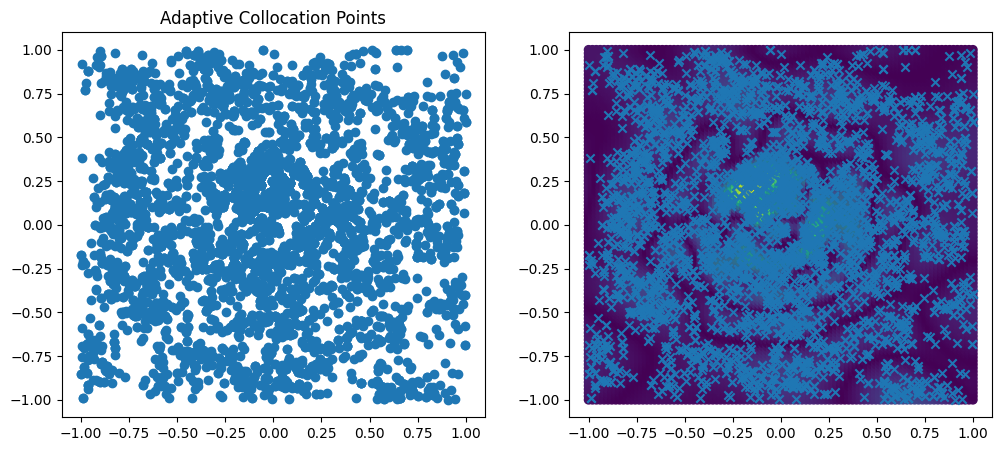

Epoch 300, Loss 0.16115868091583252, mse : 1.527455698210626,l2_error: 0.0016415961267918977


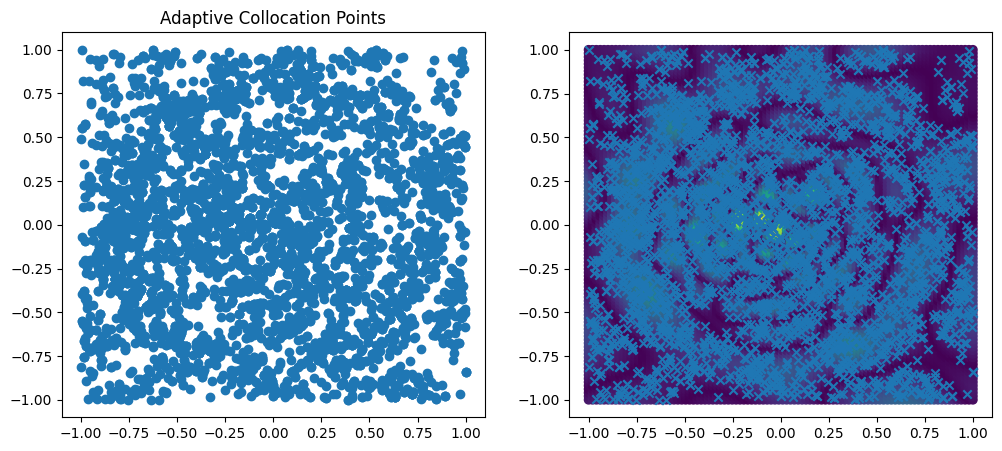

Epoch 400, Loss 0.06235650181770325, mse : 0.18875597070724615,l2_error: 0.00017986751979317788


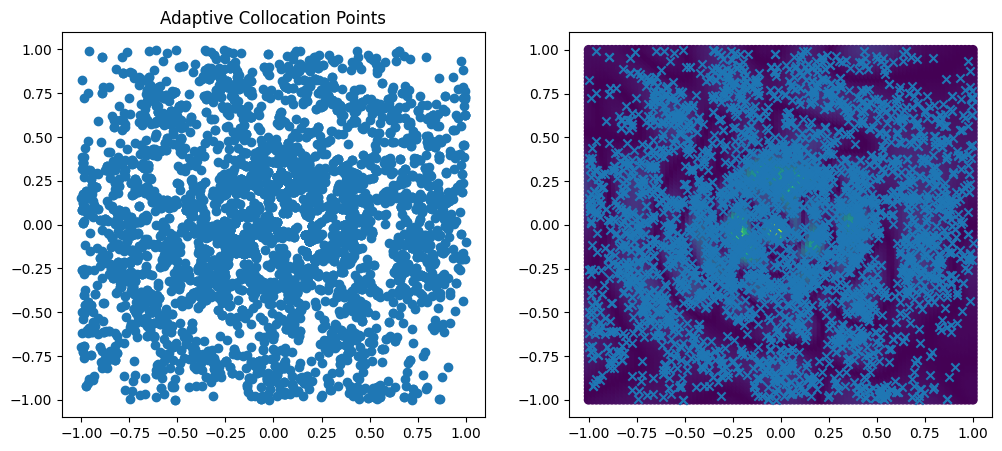

Epoch 500, Loss 0.03882847726345062, mse : 0.441332787694538,l2_error: 0.00048284037341940657


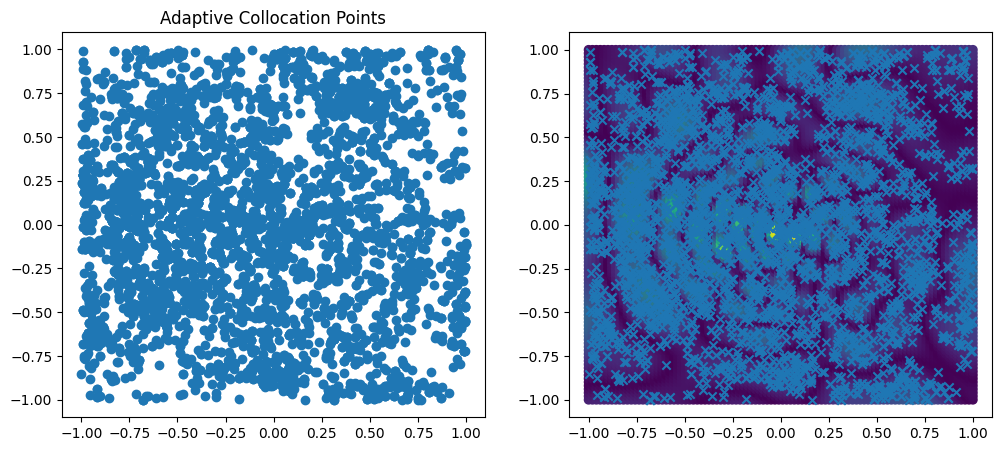

Epoch 600, Loss 0.012096759863197803, mse : 0.048719715332924025,l2_error: 6.874221899512897e-05


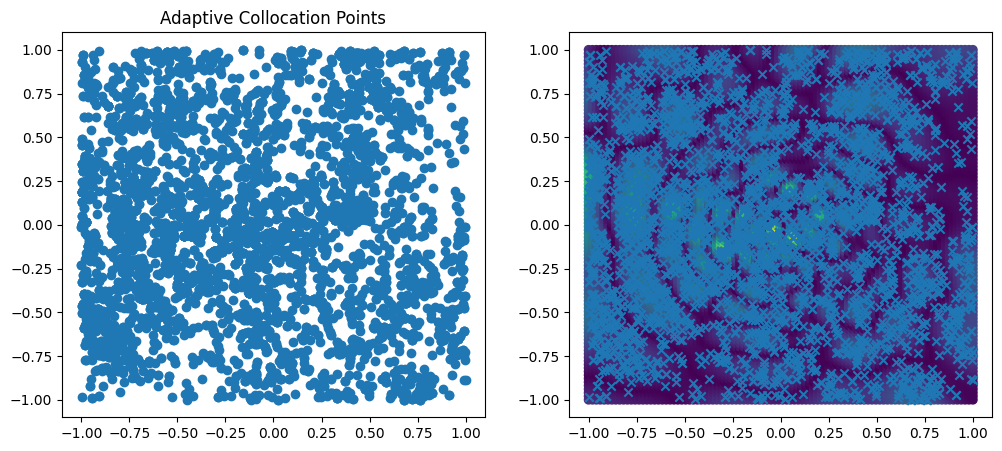

Epoch 700, Loss 0.0049632578156888485, mse : 0.02072665051757989,l2_error: 3.931170803922678e-05


In [7]:


pinn2 = Net(2, 1, 50, 4)
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)

x, y = torch.meshgrid(x, y)
np.random.seed(0)

# random points between -1 and 1
x_adaptive, y_adaptive = create_grid(10000)

indices = torch.randint(0, 100, (2500, 2))

MSE = []
L2_ERROR = []
LOSS = []
W_i =[]
W_bc = []
W_f = []
x2 ,y2 = select_random_points(x_adaptive, y_adaptive, 5000)
x2, y2 = torch.tensor(x2).unsqueeze(1).float(),torch.tensor(y2).unsqueeze(1).float()

x2.requires_grad = True
y2.requires_grad = True
    


weight_bc = torch.tensor(1.0, requires_grad=True)
weight_i = torch.tensor(1.0, requires_grad=True)
weight_f = torch.tensor(1.0, requires_grad=True)
optimizer = torch.optim.Adam([{'params':pinn2.parameters()} ,{'params':[weight_bc, weight_i, weight_f]} ], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
for epoch in range(701):
    check_for_interrupt()


    optimizer.zero_grad()
    loss2 = loss_boundary_1(x.flatten().unsqueeze(1), pinn2)
    loss3 = loss_boundary_2(x.flatten().unsqueeze(1), pinn2)
    loss4 = loss_boundary_3(y.flatten().unsqueeze(1), pinn2)
    loss_for_adaptive_points = loss_fn2(x2, y2, pinn2)
    loss5 = loss_boundary_4(y.flatten().unsqueeze(1), pinn2)
    loss_f = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn2)

    loss = ((loss_f + loss_for_adaptive_points)*tf.exp(-weight_f) +  (loss3 + loss4)*tf.exp(-weight_bc) + (loss2 + loss5)*tf.exp(-weight_i) + torch.abs(weight_bc)**2 + torch.abs(weight_i)**2 + torch.abs(weight_f)**2)*0.5
    loss.backward(retain_graph=True)
   
    optimizer.step()
    scheduler.step()

    #weight_bc = np.exp(-(loss3 + loss4).detach().numpy())
    #weight_i = np.exp(-(loss2 + loss5).detach().numpy())
    #weight_f = np.exp(-(loss_f + loss_for_adaptive_points).detach().numpy())

    """magnitude = f2(x2, y2, pinn2)
    magnitude = torch.sqrt(magnitude).detach().numpy()

    err = magnitude ** 5 / np.mean(magnitude ** 5)
    
    p = err / np.sum(err)
    idx = np.random.choice(range(len(x2)), 400,replace=False, p=p.flatten())
    idy = np.random.choice(range(len(y2)), 400,replace=False, p=p.flatten())
    x2_copy = x2.clone()
    y2_copy = y2.clone()

    x2_copy = x2_copy[idx]
    y2_copy = y2_copy[idx]

    x2.data = x2_copy.data
    y2.data = y2_copy.data"""

    if epoch%100 == 0: 
        
        x2, y2 = adaptive_collocation_points(x2, y2, pinn2, k=1.0)
        risid = f2(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn2)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].scatter(x2.detach().numpy(), y2.detach().numpy())
        ax[0].set_title("Adaptive Collocation Points")
        ax[1].scatter(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), c=risid.detach().numpy().flatten(), cmap='viridis')
        plt.scatter(x2.detach().numpy(), y2.detach().numpy(),marker='x')
        plt.show()
        x2 ,y2 = select_random_points(x_adaptive, y_adaptive, 5000)
        x2, y2 = torch.tensor(x2).unsqueeze(1).float(),torch.tensor(y2).unsqueeze(1).float()

        x2.requires_grad = True
        y2.requires_grad = True
    
        
    W_i.append(tf.exp(-weight_i).detach().numpy())
    W_bc.append(tf.exp(-weight_bc).detach().numpy())
    W_f.append(tf.exp(-weight_f).detach().numpy())



    






    if epoch%100 == 0:
        u_pred_2 = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2)
        u_pred_2 = u_pred_2.reshape(100, 100)
        u_pred_2 = u_pred_2.detach().numpy()
        MSE.append(np.mean((u_ex - 100*u_pred_2) ** 2))
        LOSS.append(loss.item())
        L2_ERROR.append(np.linalg.norm((u_ex - 100*u_pred_2) ** 2)/np.linalg.norm((u_ex ) ** 2))
        
        print(f'Epoch {epoch}, Loss {loss.item()}, mse : {MSE[-1]},l2_error: {L2_ERROR[-1]}')
        #plt.scatter(x2.detach().numpy(), y2.detach().numpy())
        #plt.show()
            


tensor(1.0000, grad_fn=<ExpBackward0>) tensor(1.0000, grad_fn=<ExpBackward0>) tensor(0.9109, grad_fn=<ExpBackward0>) tensor(0.6214, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0172, grad_fn=<MulBackward0>)


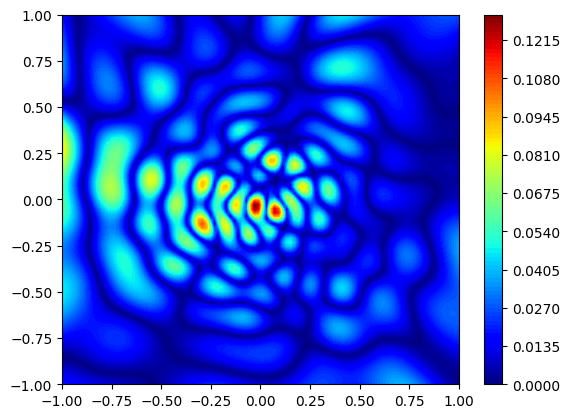

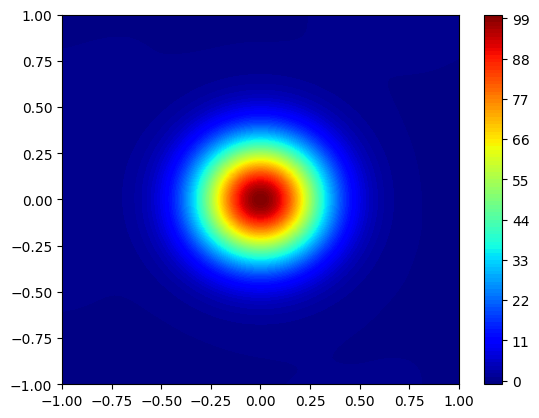

In [8]:
import matplotlib.pyplot as plt
print(tf.exp(-weight_bc),tf.exp(-weight_i),tf.exp(-weight_f) ,loss_f*10**3,loss2*10**3,loss3*10**3,loss4*10**3,loss5*10**3)
x = torch.linspace(1,-1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
risid = f2(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn2)


u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2)
#inverse scaling on the boundarys
u_pred = u_pred.reshape(100, 100)
u_pred = u_pred.detach().numpy()

plt.contourf(x.detach().numpy(), y.detach().numpy(),risid.detach().numpy().reshape(100,100),levels =100, cmap='jet')
plt.colorbar()
plt.show()


plt.contourf(x.detach().numpy(), y.detach().numpy(), 100*u_pred,levels =100, cmap='jet')
plt.colorbar()
plt.show()

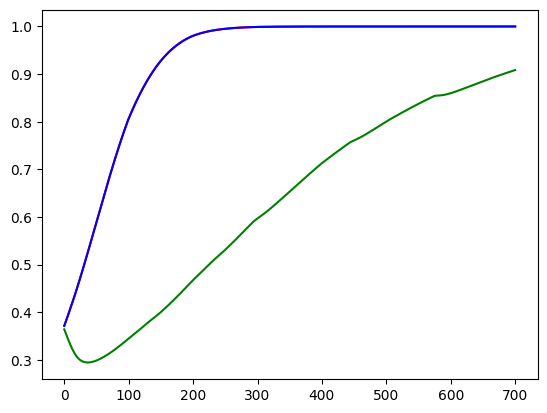

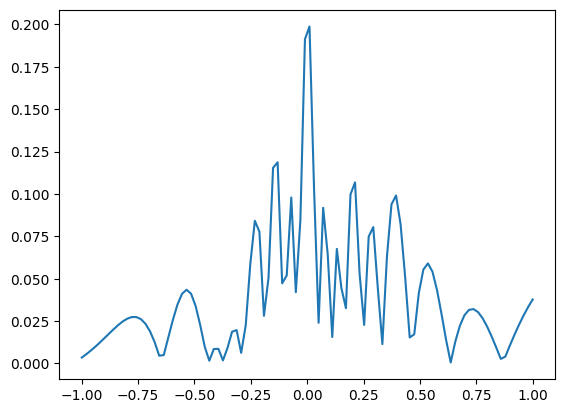

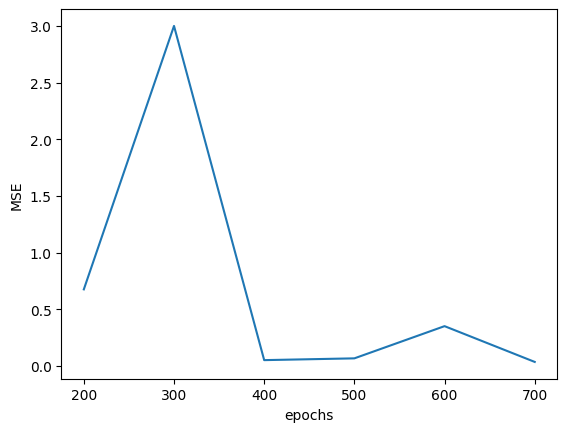

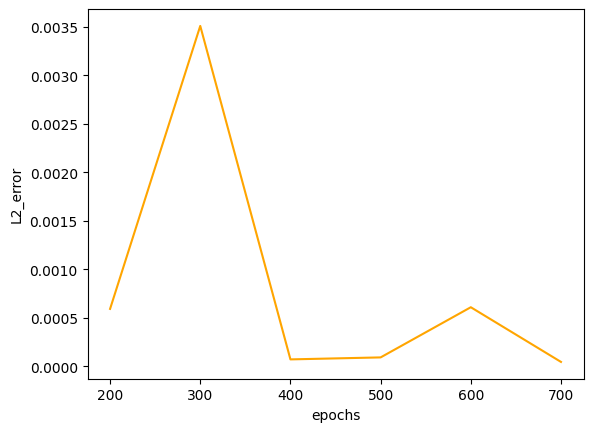

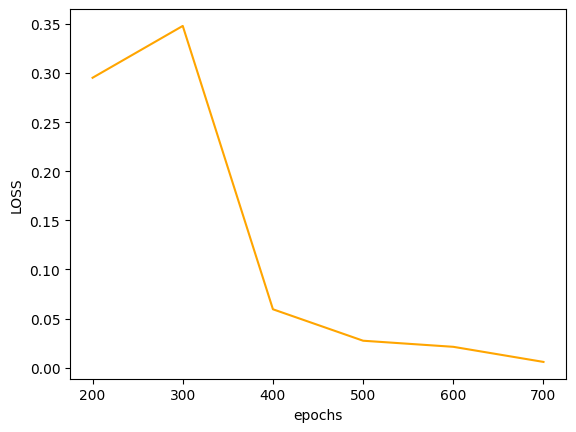

In [39]:
epochs = [i*100 for i in range(2,8)]
x = torch.linspace(-1, 1, 1000)
y = torch.linspace(-1, 1, 1000)
risidual = f2(x.unsqueeze(1), y.unsqueeze(1),pinn2)

plt.plot(W_i ,label = 'W_i',color = 'red')
plt.plot(W_bc ,label = 'W_bc',color = 'blue')
plt.plot(W_f ,label = 'W_f',color = 'green')
plt.show()

plt.plot(x.flatten().detach().numpy(),risidual.detach().numpy()  )
plt.show()
plt.plot(epochs ,MSE[2:]  )
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.show()

plt.plot(epochs ,L2_ERROR[2:] ,color = 'orange' )
plt.xlabel("epochs")
plt.ylabel("L2_error")
plt.show()

plt.plot(epochs ,LOSS[2:] ,color = 'orange' )
plt.xlabel("epochs")
plt.ylabel("LOSS")
plt.show()

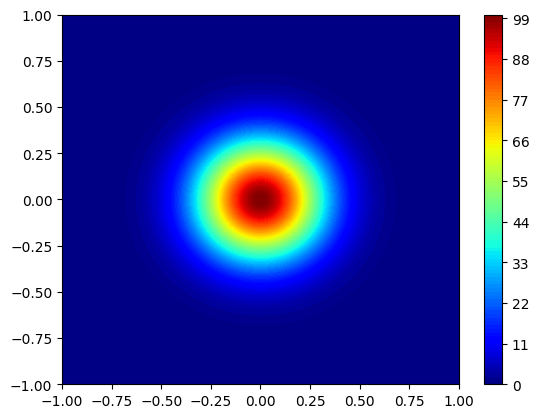

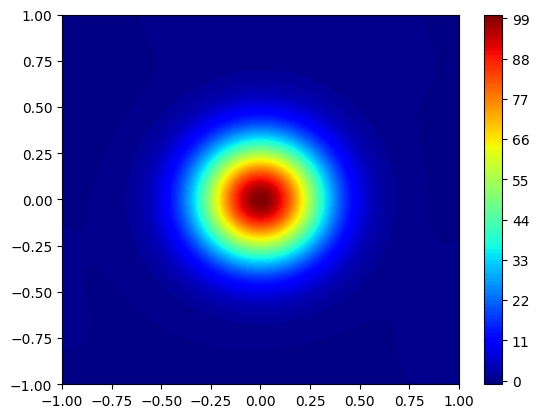

In [10]:
import numpy as np
import matplotlib.pyplot as plt
def u_exact(x , y):
    return np.exp(-10*(x**2 + y**2))*100

x= np.linspace(-1,1,100)
y= np.linspace(-1,1,100)
x,y = np.meshgrid(x,y)
u_ex = u_exact(x,y)

plt.contourf(x, y, u_ex,levels = 100 , cmap='jet')
plt.colorbar()
plt.show()




plt.contourf(x, y, 100*u_pred,levels = 100 , cmap='jet')
plt.colorbar()
plt.show()